In [8]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')
// Get the current notebook name (for backup purposes)

<IPython.core.display.Javascript object>

In [9]:
### BACKUP THE CURRENT NOTEBOOK TO S3 ###
import boto3 
import os 
backup_bucket_name = "backups-final"
s3_client = boto3.client(
    's3',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY')
)
nb_full_path = os.path.join(os.getcwd(), nb_name)
s3_client.upload_file(nb_full_path, backup_bucket_name, nb_name)

In [10]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import functions

In [11]:
sql = SQLContext(sc)

In [12]:
data_dir = 's3://geo-final'
out_dir = 's3://cleaned-geo-final'
geo_file = data_dir + '/lat_longs.txt'
clean_latlon_file = out_dir + '/clean_lat_longs.txt'

In [13]:
from pyspark.sql.types import *

geo_df_schema = StructType(
  [StructField('Latitude', DoubleType()),
   StructField('Longitude', DoubleType()),
   StructField('page_name', StringType())]
)


In [14]:
geo_df = spark.read.options(header=False, sep=' ').schema(geo_df_schema).csv(geo_file)

In [15]:
geo_df = geo_df.drop('page_name').filter(geo_df.Latitude.isNotNull()).filter(geo_df.Longitude.isNotNull())
geo_df.show()

[Stage 0:>                                                          (0 + 1) / 1]

+-------------------+------------------+
|           Latitude|         Longitude|
+-------------------+------------------+
|               36.7| 3.216666666666667|
|               42.5|1.5166666666666666|
| 12.516666666666667|-70.03333333333333|
| -8.833333333333334|13.333333333333334|
| 41.333333333333336|              19.8|
|  34.53333333333333| 69.13333333333334|
| 40.416666666666664|49.833333333333336|
|  39.93333333333333| 32.86666666666667|
|  52.36666666666667|               4.9|
|              50.46|              2.13|
| 17.116666666666667|            -61.85|
|  57.04638888888889| 9.919166666666667|
|              56.15|10.216666666666667|
|             34.929|           138.601|
|  42.03472222222222|            -93.62|
|  33.41972222222222|           43.3125|
|  50.78333333333333| 6.083333333333333|
|            57.1526|             -2.11|
| 36.766666666666666| 3.216666666666667|
|-15.518055555555556|-71.76527777777778|
+-------------------+------------------+
only showing top

In [16]:
geo_df.write.csv(clean_latlon_file)

In [17]:
"""
    The dataframe is converted to pandas, then a geopandas data frame to make plotting simple
"""
from shapely.geometry import Point
import geopandas as gpd
df = geo_df.drop('page_name').toPandas()
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude,df.Latitude))

<AxesSubplot:>

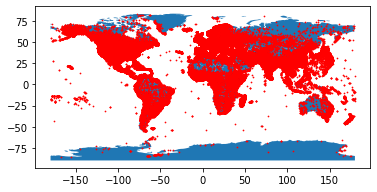

In [19]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot()
gdf.plot(ax=ax,c='red',markersize=0.5)